# Model Training & Evaluation Pipeline

Details: [Model Training Specifications](https://docs.google.com/document/d/1UiDi8nyTcfMeMNIAz3KntlVZBlYrpoMAURuDccTt-wk/edit?usp=sharing)

Model Evaluation: Identify best parameters for each model

In [ ]:
# Basic Libraries

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data Source

df = pd.read_csv("/content/drive/MyDrive/Senior Project/Datasets/test_gee.csv")
# df = pd.read_csv("/content/drive/MyDrive/Senior Project/Datasets/test.csv")

df = df.drop(columns = ['Unnamed: 0', 'lat_min', 'lat_max', 'long_min', 'long_max','DAYNIGHT'], axis=1)
df.head()

,LATITUDE,LONGITUDE,BRIGHTNESS,ACQ_DATE,ACQ_TIME,BRIGHT_T31,FireOccurred,CO_mol/m2,SO2_mol/m2,NO2_mol/m2,O3_mol/m2,A_NAME_E,INSTRUMENT
0,9.9564,98.6264,311.7,11/22/2018,07:00:00,296.7,0,0.029759,-0.000030,0.000048,0.112910,288,0
1,13.9029,101.0592,314.4,11/22/2018,07:00:00,293.4,0,0.035132,0.000080,0.000073,0.110186,38,0
2,15.0922,100.1598,313.3,11/22/2018,07:00:00,298.0,0,0.033847,0.000113,0.000040,0.111066,602,0
3,15.0922,100.1598,313.3,11/22/2018,07:00:00,298.0,0,0.033847,0.000113,0.000048,0.111066,602,0
4,15.0922,100.1598,313.3,11/22/2018,07:00:00,298.0,0,0.033263,-0.000102,0.000053,0.110693,88,0


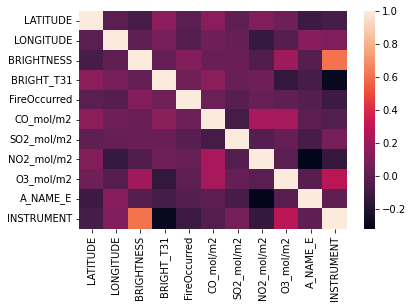

In [ ]:
import seaborn as sb

dataplot = sb.heatmap(df.corr())
plt.show()

In [ ]:
df.describe()

,LATITUDE,LONGITUDE,BRIGHTNESS,BRIGHT_T31,FireOccurred,CO_mol/m2,SO2_mol/m2,NO2_mol/m2,O3_mol/m2,A_NAME_E,INSTRUMENT
count,154401.000000,154401.000000,154401.000000,154401.000000,154401.000000,154401.000000,154401.000000,154401.000000,154401.000000,154401.000000,154401.000000
mean,16.047687,100.157863,334.858491,303.290543,0.011794,0.047323,0.000042,0.000069,0.114821,364.898271,0.565748
std,1.602365,1.325161,12.562253,5.917158,0.107958,0.012502,0.000270,0.000033,0.005504,221.360660,0.495660
min,5.769100,97.639360,207.900000,268.600000,0.000000,0.019729,-0.000826,0.000025,0.097542,0.000000,0.000000
25%,14.868000,99.300700,325.900000,299.800000,0.000000,0.038082,-0.000080,0.000052,0.111099,88.000000,0.000000
50%,16.130580,99.856200,333.700000,303.600000,0.000000,0.044174,0.000004,0.000064,0.113748,364.000000,1.000000
75%,17.349900,100.708690,341.100000,307.100000,0.000000,0.054663,0.000132,0.000080,0.118206,602.000000,1.000000
max,20.386200,105.564550,502.300000,400.100000,1.000000,0.137340,0.002840,0.000518,0.132321,610.000000,1.000000


In [ ]:
df.dtypes

LATITUDE        float64
LONGITUDE       float64
BRIGHTNESS      float64
ACQ_DATE         object
ACQ_TIME         object
BRIGHT_T31      float64
FireOccurred      int64
CO_mol/m2       float64
SO2_mol/m2      float64
NO2_mol/m2      float64
O3_mol/m2       float64
A_NAME_E          int64
INSTRUMENT        int64
dtype: object

In [ ]:
display(df['FireOccurred'].value_counts())
print("Column numbers: ", len(df.columns))

0    152580
1      1821
Name: FireOccurred, dtype: int64

Column numbers:  13


In [ ]:
display(df['ACQ_DATE'].value_counts())

02/14/2020    14432
04/02/2020    12377
01/28/2020    10654
02/22/2020    10545
02/13/2020     4854
              ...  
10/21/2019        1
10/03/2019        1
06/27/2019        1
06/06/2019        1
09/28/2021        1
Name: ACQ_DATE, Length: 399, dtype: int64

In [ ]:
display(df['ACQ_TIME'].value_counts())

07:00:00    121008
06:00:00     33393
Name: ACQ_TIME, dtype: int64

In [ ]:
X = df.drop('FireOccurred', axis=1)
y = df['FireOccurred']

In [ ]:
# Encoder

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

labelEncoder = LabelEncoder()
ordinalEncoder = OrdinalEncoder()

X[['ACQ_TIME','ACQ_DATE']] = ordinalEncoder.fit_transform(X[['ACQ_TIME','ACQ_DATE']])
X.head()

# for i in range(len(df.columns)-1):
#   X.iloc[:,i] = labelEncoder.fit_transform(X.iloc[:,i])

,LATITUDE,LONGITUDE,BRIGHTNESS,ACQ_DATE,ACQ_TIME,BRIGHT_T31,CO_mol/m2,SO2_mol/m2,NO2_mol/m2,O3_mol/m2,A_NAME_E,INSTRUMENT
0,9.9564,98.6264,311.7,345.0,1.0,296.7,0.029759,-0.000030,0.000048,0.112910,288,0
1,13.9029,101.0592,314.4,345.0,1.0,293.4,0.035132,0.000080,0.000073,0.110186,38,0
2,15.0922,100.1598,313.3,345.0,1.0,298.0,0.033847,0.000113,0.000040,0.111066,602,0
3,15.0922,100.1598,313.3,345.0,1.0,298.0,0.033847,0.000113,0.000048,0.111066,602,0
4,15.0922,100.1598,313.3,345.0,1.0,298.0,0.033263,-0.000102,0.000053,0.110693,88,0


In [ ]:
# Scaler

from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler()
X = pd.DataFrame(standardScaler.fit_transform(X),columns = X.columns)

display(X)

,LATITUDE,LONGITUDE,BRIGHTNESS,ACQ_DATE,ACQ_TIME,BRIGHT_T31,CO_mol/m2,SO2_mol/m2,NO2_mol/m2,O3_mol/m2,A_NAME_E,INSTRUMENT
0,-3.801448,-1.155685,-1.843504,2.762139,0.525316,-1.113806,-1.404865,-0.267384,-0.666659,-0.347228,-0.347390,-1.141406
1,-1.338518,0.680174,-1.628574,2.762139,0.525316,-1.671508,-0.975125,0.140162,0.104568,-0.842165,-1.476772,-1.141406
2,-0.596300,0.001461,-1.716138,2.762139,0.525316,-0.894105,-1.077910,0.259693,-0.892463,-0.682295,1.071114,-1.141406
3,-0.596300,0.001461,-1.716138,2.762139,0.525316,-0.894105,-1.077910,0.259693,-0.664960,-0.682295,1.071114,-1.141406
4,-0.596300,0.001461,-1.716138,2.762139,0.525316,-0.894105,-1.124594,-0.533491,-0.514292,-0.750024,-1.250896,-1.141406
...,...,...,...,...,...,...,...,...,...,...,...,...
154396,-1.139836,0.084802,-0.133614,2.341891,0.525316,-3.016753,-1.693108,-0.722421,0.242585,1.051594,-1.436115,0.876112
154397,-1.139836,0.084802,-0.133614,2.341891,0.525316,-3.016753,-1.707541,-0.722421,0.242585,1.051594,-1.436115,0.876112
154398,-1.139836,0.084802,-0.133614,2.341891,0.525316,-3.016753,-1.693108,-0.722421,0.135014,1.051594,-1.436115,0.876112
154399,-1.139836,0.084802,-0.133614,2.341891,0.525316,-3.016753,-1.707541,-0.722421,0.135014,1.051594,-1.436115,0.876112


In [ ]:
# Training, Validation, Testing Split

from sklearn.model_selection import train_test_split

# 80:10:10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=10, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=10, shuffle=True)

Original = [X_train, X_val, X_test, y_train, y_val, y_test] # For reference

In [ ]:
if len(X_train)==len(y_train) and len(X_test) == len(y_test) and len(X_val) == len(y_val):
  print("X and y data length matching")
else:
  print("Error in data preparation pipeline")
print()
print("No. of training data = %d" % len(X_train))
print("No. of validation data = %d" % len(X_val))
print("No. of testing data = %d" % len(X_test))

X and y data length matching

No. of training data = 123520
No. of validation data = 15440
No. of testing data = 15441


In [ ]:
display(y_test.value_counts())

0    15282
1      159
Name: FireOccurred, dtype: int64

In [ ]:
# SMOTE

from collections import Counter
from imblearn.over_sampling import SMOTE 

print('Original dataset shape %s' % Counter(y_train))
sm = SMOTE(random_state=10)
X_train, y_train = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 122045, 1: 1475})
Resampled dataset shape Counter({0: 122045, 1: 122045})


In [ ]:
# Evaluation Metrics

from sklearn.metrics import confusion_matrix, recall_score, f1_score, roc_auc_score, accuracy_score

def evaluation_metrics(y_true, y_pred):
  cfm = confusion_matrix(y_true, y_pred).ravel()
  acc = accuracy_score(y_true, y_pred)
  recs = recall_score(y_true, y_pred, average='binary')
  f1s = f1_score(y_true, y_pred, average='binary')
  rocs = roc_auc_score(y_true, y_pred, average='macro')
  return [cfm, acc, recs, f1s, rocs]

Confusion matrix format : [ tn , fp , fn , tp ]

In [ ]:
# Store Model Parameters and Eval

models = pd.DataFrame(columns = ['model_name', 'model', 'parameters'])
models_eval = pd.DataFrame(columns = ['model_name', 'confusion_matrix', 'accuracy', 'recall', 'f1_score', 'roc_auc_score'])

In [ ]:
# Import ML Algorithms

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import VotingClassifier

# RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

# Save Model

import pickle

## Logistic Regression

- Library: Scikit-learn

In [ ]:
# Training

name = 'log_clf'

train = pd.DataFrame(columns = ['penalty', 'warm_start', 'solver', 'max_iter', 'dual', 'n_jobs','random_state'])
train = train.append({'penalty' : 'none', 'warm_start': False, 'solver': 'newton-cg',  'max_iter': 247,  'dual': False, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)
train = train.append({'penalty' : 'l2', 'warm_start': False, 'solver': 'newton-cg',  'max_iter': 100,  'dual': False, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)


train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    log_clf = LogisticRegression(penalty = row['penalty'], n_jobs = int(row['n_jobs']), random_state = int(row['random_state']))
    log_clf.fit(X_train, y_train)
   
    y_true = y_val
    y_pred = log_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': log_clf, 
                            'parameters': log_clf.get_params()}, 
                           ignore_index=True)
   
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                     ignore_index=True)

In [ ]:
# RandomizedSearchCV

random_grid = {
                "penalty": ['l1', 'l2', 'elasticnet', 'none'],
                "dual": [True, False],
                "max_iter" : [int(x) for x in np.linspace(100, 500, num = 20)],
                "warm_start" : [True, False],
                "solver" : ['lbfgs', 'newton-cg', 'liblinear'],
                "C" : [int(x) for x in np.linspace(0, 1, num = 50)]
              }

log_random = RandomizedSearchCV(estimator = log_clf, 
                                param_distributions = random_grid, 
                                n_iter = 50, 
                                cv = 3, 
                                verbose=2, 
                                random_state=10)

log_random.fit(X_train, y_train)
log_random.best_params_

In [ ]:
display(models_eval)

## Support Vector Machine (SVM)

- Library: Scikit-learn
- Deprecated. Poor performance no matter what.

SVMs is very computationally expensive and demanding

Kernelized SVMs require the computation of a distance function between each point in the dataset, which is the dominating cost of $n$ features x $𝑛^{2}$ observations

If the cache is getting thrashed then the running time blows up to $n$ features × $𝑛^{3}$ observations)

Solutions:
* Scale data to $[-1,1]$
* Use less samples

In [ ]:
X_train_SVM = Original[0]
X_val_SVM = Original[1]
y_train_SVM = Original[3]
y_val_SVM = Original[4]

In [ ]:
display(y_train_SVM.value_counts())

In [ ]:
# Undersampling

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=10)
X_train_SVM, y_train_SVM = rus.fit_resample(X_train_SVM, y_train_SVM)

In [ ]:
display(y_train_SVM.value_counts())

In [ ]:
# Training

name = 'svc_clf'

train = pd.DataFrame(columns = ['kernel', 'random_state'])
train = train.append({'kernel' : 'rbf', 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'sigmoid', 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'linear', 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    print("Currently at :" , model_name)
    svc_clf = SVC(kernel=row["kernel"], random_state = int(row["random_state"]))
    svc_clf.fit(X_train_SVM, y_train_SVM)
    
    y_true = y_val_SVM
    y_pred = svc_clf.predict(X_val_SVM)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': svc_clf, 
                            'parameters': svc_clf.get_params()}, 
                           ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                     ignore_index=True)

In [ ]:
# RandomizedSearchCV

random_grid = {
              "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
              "C": np.arange(2, 10, 2),
              "gamma": np.arange(0.1, 1, 0.2)
             }

svc_random = RandomizedSearchCV(estimator = svc_clf, 
                                 param_distributions = random_grid, 
                                  n_iter = 50, 
                                  cv = 3, 
                                  verbose=2, 
                                  random_state=10)

svc_random.fit(X_train, y_train)
svc_random.best_params_

In [ ]:
display(models_eval)

## Naive Bayes

- Library: Scikit-learn
- Shuffling does not affect the model building. No random_state.
- RandomizedSearchCV is not appropriate since there is only 1 parameter and the value is close to 0. Choose from models_eval.

In [ ]:
# Training

name = 'bayes_clf'

train = pd.DataFrame(columns = ['var_smoothing'])
train = train.append({'var_smoothing': 1e-10}, ignore_index=True)
train = train.append({'var_smoothing': 1e-20}, ignore_index=True)
train = train.append({'var_smoothing': 0}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    bayes_clf = GaussianNB(var_smoothing = row['var_smoothing'])
    bayes_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = bayes_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': bayes_clf, 
                            'parameters': bayes_clf.get_params()}, 
                           ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                     ignore_index=True)

In [ ]:
display(models_eval)

## K-Nearest Neighbor

- Library: Scikit-learn
- Shuffling does not affect the model building. No random_state.

In [ ]:
# Training

name = 'neigh_clf'

train = pd.DataFrame(columns = ['n_neighbors', 'algorithm', 'n_jobs'])
train = train.append({'n_neighbors': 5, 'algorithm':'auto', 'n_jobs':-1}, ignore_index=True)
train = train.append({'n_neighbors': 1, 'algorithm':'auto', 'n_jobs':-1}, ignore_index=True)
train = train.append({'n_neighbors': 20, 'algorithm':'kd_tree', 'n_jobs':-1}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    neigh_clf = KNeighborsClassifier(n_neighbors=int(row['n_neighbors']), algorithm = row['algorithm'], n_jobs = int(row['n_jobs']))
    neigh_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = neigh_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': neigh_clf, 
                            'parameters': neigh_clf.get_params()}, 
                           ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                     ignore_index=True)

In [ ]:
# RandomizedSearchCV

random_grid = {
                "n_neighbors": [int(x) for x in np.linspace(1, 20, num = 20)],
                "algorithm": ['auto', 'kd_tree','ball_tree']
              }

neigh_random = RandomizedSearchCV(estimator = neigh_clf, 
                                  param_distributions = random_grid, 
                                  n_iter = 50, 
                                  cv = 3, 
                                  verbose=2, 
                                  random_state=10)

rand = RandomizedSearchCV(knn, param_grid, cv=10, scoring='accuracy', n_iter=10, random_state=10)

neigh_random.fit(X_train, y_train)
neigh_random.best_params_

In [ ]:
display(models_eval)

## Decision Tree

- Library: Scikit-learn

In [104]:
# Training

name = 'tree_clf'

train = pd.DataFrame(columns = ['criterion', 'splitter', 'min_samples_leaf', 'max_features', 'max_depth', 'n_jobs', 'random_state'])
train = train.append({'criterion' : 'gini', 'splitter': 'best', 'min_samples_leaf': 1, 'max_features': 9, 'max_depth': None, 'random_state': 10}, ignore_index=True)
train = train.append({'criterion' : 'entropy', 'splitter': 'best', 'min_samples_leaf': 1, 'max_features': 9, 'max_depth': None, 'random_state': 10}, ignore_index=True)
train = train.append({'criterion' : 'gini', 'splitter': 'random', 'min_samples_leaf': 1, 'max_features': "auto", 'max_depth': None, 'random_state': 10}, ignore_index=True)
train = train.append({'criterion' : 'entropy', 'splitter': 'random', 'min_samples_leaf': 1, 'max_features': "auto", 'max_depth': None, 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    tree_clf = DecisionTreeClassifier(criterion = row['criterion'], splitter = row['splitter'], max_depth = None, random_state = row['random_state'])
    tree_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = tree_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': tree_clf, 
                            'parameters': tree_clf.get_params()}, 
                           ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                     ignore_index=True)

In [102]:
# RandomizedSearchCV

max_depth = list([int(x) for x in np.linspace(2, 6, num = 5)])
max_depth.append(None)

random_grid = {
              "max_depth": max_depth,
              "max_features": [int(x) for x in np.linspace(1, len(df.columns), num = len(df.columns))],
              "min_samples_leaf": [int(x) for x in np.linspace(1, len(df.columns), num = len(df.columns))],
              "criterion": ["gini", "entropy", "log_loss"],
              "splitter": ["random", "best"]
              }

tree_random = RandomizedSearchCV(estimator = tree_clf, 
                                 param_distributions = random_grid, 
                                 n_iter = 50, 
                                 cv = 3, 
                                 verbose=2, 
                                 random_state=10)

tree_random.fit(X_train, y_train)
tree_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END criterion=gini, max_depth=5, max_features=11, min_samples_leaf=8, splitter=best; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=11, min_samples_leaf=8, splitter=best; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=11, min_samples_leaf=8, splitter=best; total time=   0.6s
[CV] END criterion=log_loss, max_depth=3, max_features=9, min_samples_leaf=11, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=3, max_features=9, min_samples_leaf=11, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=3, max_features=9, min_samples_leaf=11, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=13, min_samples_leaf=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=13, min_samples_leaf=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_featur

KeyboardInterrupt: ignored

In [105]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,rnd_clf0,"[15249, 4, 10, 177]",0.999093,0.946524,0.961957,0.973131
1,rnd_clf1,"[15248, 5, 9, 178]",0.999093,0.951872,0.962162,0.975772
2,rnd_clf2,"[15248, 5, 9, 178]",0.999093,0.951872,0.962162,0.975772
3,tree_clf0,"[15234, 19, 9, 178]",0.998187,0.951872,0.927083,0.975313
4,tree_clf1,"[15228, 25, 6, 181]",0.997992,0.967914,0.921120,0.983138
5,tree_clf2,"[15230, 23, 9, 178]",0.997927,0.951872,0.917526,0.975182
6,tree_clf3,"[15227, 26, 10, 177]",0.997668,0.946524,0.907692,0.972410
7,tree_clf0,"[15227, 26, 10, 177]",0.997668,0.946524,0.907692,0.972410
8,tree_clf1,"[15228, 25, 6, 181]",0.997992,0.967914,0.921120,0.983138
9,tree_clf2,"[15230, 23, 9, 178]",0.997927,0.951872,0.917526,0.975182


## Random Forest Classifier

- Library: Scikit-learn

In [ ]:
# Training

name = 'rnd_clf'

train = pd.DataFrame(columns = ['n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_features','max_depth', 'n_jobs', 'random_state'])
train = train.append({'n_estimators' : 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth' : None, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)
train = train.append({'n_estimators' : 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth' : 31, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)
train = train.append({'n_estimators' : 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth' : None, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    rnd_clf = RandomForestClassifier(n_estimators = int(row['n_estimators']), max_depth = None, 
                                    n_jobs = int(row['n_jobs']), random_state = int(row['random_state']))
    rnd_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = rnd_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': rnd_clf, 
                            'parameters': rnd_clf.get_params()}, 
                           ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                     ignore_index=True)

In [ ]:
# RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 500, num = 20)]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(1, len(df.columns), num = len(df.columns))]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(15, 35, num = 7)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }

rnd_random = RandomizedSearchCV(estimator = rnd_clf, 
                                param_distributions = random_grid, 
                                n_iter = 50, 
                                cv = 3, 
                                verbose=2, 
                                random_state=10)

rnd_random.fit(X_train, y_train)
rnd_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END max_depth=28, max_features=7, min_samples_leaf=4, min_samples_split=5, n_estimators=436; total time= 3.2min


KeyboardInterrupt: ignored

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,rnd_clf0,"[15249, 4, 10, 177]",0.999093,0.946524,0.961957,0.973131
1,rnd_clf1,"[15248, 5, 9, 178]",0.999093,0.951872,0.962162,0.975772
2,rnd_clf2,"[15248, 5, 9, 178]",0.999093,0.951872,0.962162,0.975772


## Gradient Boosting Classifier

- Library: Scikit-learn

In [ ]:
# Training

name = 'gboost_clf'

train = pd.DataFrame(columns = ['n_estimators', 'learning_rate', 'max_depth', 'random_state'])
train = train.append({'n_estimators': 100, 'learning_rate':0.1, 'max_depth':3, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 500, 'learning_rate':0.5, 'max_depth':1, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 50, 'learning_rate':0.01, 'max_depth':10, 'random_state':10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    gboost_clf = GradientBoostingClassifier(n_estimators=int(row['n_estimators']), learning_rate=row['learning_rate'],
                                            max_depth=int(row['max_depth']), random_state=int(row['random_state']))
    gboost_clf.fit(X_train, y_train)
   
    y_true = y_val
    y_pred = gboost_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': gboost_clf, 
                            'parameters': gboost_clf.get_params()}, 
                           ignore_index=True)
   
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                     ignore_index=True)

## XGBoost

- Library: xgboost

In [ ]:
# Training

name = 'xgboost_clf'

train = pd.DataFrame(columns = ['n_estimators', 'learning_rate', 'max_depth', 'random_state'])
train = train.append({'n_estimators': 1000, 'learning_rate':0.0001, 'max_depth':3, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 500, 'learning_rate':0.5, 'max_depth':1, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 750, 'learning_rate':0.01, 'max_depth':10, 'random_state':10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    xgboost_clf = XGBClassifier(n_estimators=int(row['n_estimators']), learning_rate=row['learning_rate'],
                                max_depth=int(row['max_depth']), random_state=int(row['random_state']))
    xgboost_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = xgboost_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': xgboost_clf, 
                            'parameters': xgboost_clf.get_params()}, 
                           ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                     ignore_index=True)

## LightGBM

- Library: lightbgm

In [ ]:
# Training

name = 'lightgbm_clf'

train = pd.DataFrame(columns = ['n_estimators', 'learning_rate', 'max_depth', 'random_state'])
train = train.append({'n_estimators': 1000, 'learning_rate':0.1, 'max_depth':3, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 500, 'learning_rate':0.5, 'max_depth':1, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 750, 'learning_rate':0.01, 'max_depth':10, 'random_state':10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    lightgbm_clf = LGBMClassifier(n_estimators=int(row['n_estimators']), learning_rate=row['learning_rate'],
                                max_depth=int(row['max_depth']), random_state=int(row['random_state']))
    lightgbm_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = lightgbm_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)   

    models = models.append({'model_name': model_name, 
                            'model': lightgbm_clf, 
                            'parameters': lightgbm_clf.get_params()}, 
                           ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                     ignore_index=True)

## Artificial Neural Network

- Library: Keras, Tensorflow

In [ ]:
tf.random.set_seed(10)

print(tf.__version__)
print(keras.__version__)

#### Experiment 1: Base Model

In [ ]:
X_train.info()

In [ ]:
ann_clf = keras.models.Sequential([
    keras.layers.Dense(17, input_shape=(X_train.shape[1],), activation='relu'), # 16 columns. 1 bias term to accelerate activation of a node.
    keras.layers.Dense(8, activation='relu'), # One hidden layer is sufficient for the large majority of problems. 
    # Set the number of neurons in the hidden layer as the mean of the neurons in the input and output layers.
    keras.layers.Dense(1, activation='sigmoid'), # Only 1 acceptable unless softmax activation function is used
])

ann_clf.summary()

In [ ]:
ann_clf.layers

In [ ]:
# Shuffle Data since SMOTE appends many 1s at the end

from sklearn.utils import shuffle

X_train_ANN, y_train_ANN = shuffle(X_train, y_train, random_state = 10)
y_train_ANN.value_counts()

In [ ]:
ann_clf.compile(optimizer = 'adam', 
                metrics=['accuracy'], 
                loss ='binary_crossentropy')

record = ann_clf.fit(
            X_train_ANN, 
            y_train_ANN, 
            validation_data = (X_val, y_val), 
            batch_size = 10, 
            epochs = 50)

In [ ]:
keras.utils.plot_model(ann_clf, show_shapes=True, rankdir="LR")

In [ ]:
_, train_acc = ann_clf.evaluate(X_train, y_train, verbose=0)
_, val_acc = ann_clf.evaluate(X_val, y_val, verbose=0)
_, test_acc = ann_clf.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Validation: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))

In [ ]:
plt.plot(record.history['accuracy'], label='Training')
plt.plot(record.history['val_accuracy'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()

In [ ]:
# plot training history
plt.plot(record.history['loss'], label='Training')
plt.plot(record.history['val_loss'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss Curves', fontsize=16)
plt.show()

#### Experiment 2: Different Batch Sizes

In [ ]:
# Fit a model and plot learning curve
def fit_model_1(X_train, y_train, X_test, y_test, n_batch):
  # Define Model
  ann_clf = keras.models.Sequential([
      keras.layers.Dense(6, input_shape=(X_train.shape[1],), activation='sigmoid'),
      keras.layers.Dense(6, activation='sigmoid'),
      keras.layers.Dense(6, activation='sigmoid'), 
      # keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation = 'sigmoid')
  ])

  # Compile Model
  ann_clf.compile(optimizer = 'adam',
                metrics=['accuracy'],
                loss = 'binary_crossentropy')
  
  # Fit Model
  history = ann_clf.fit(X_train_ANN,
                      y_train_ANN,
                      validation_data=(X_test, y_test),
                      epochs=100,
                      verbose=0,
                      batch_size=n_batch)

  # Plot Learning Curves
  plt.plot(history.history['accuracy'], label='train') 
  plt.plot(history.history['val_accuracy'], label='test') 
  plt.title('batch='+str(n_batch)) 
  plt.legend()

In [ ]:
# Create learning curves for different batch sizes
# batch_sizes = [4, 6, 10, 16, 32, 64, 128, 260]
batch_sizes = [10, 15, 20, 25, 30]

plt.figure(figsize=(10,15))
for i in range(len(batch_sizes)):

  # Determine the Plot Number
  plot_no = 420 + (i+1)
  plt.subplot(plot_no)

  # Fit model and plot learning curves for a batch size
  fit_model_1(X_train, y_train, X_test, y_test, batch_sizes[i])

# Show learning curves
plt.show()

#### Experiment 3: Different EPOCHs

In [ ]:
# Fit a model and plot learning curve
def fit_model_2(trainX, trainy, validX, validy, n_epoch):
  # Define Model
  ann_clf = keras.models.Sequential([
      keras.layers.Dense(6, input_shape=(X_train.shape[1],), activation='sigmoid'),
      keras.layers.Dense(6, activation='sigmoid'),
      keras.layers.Dense(6, activation='sigmoid'), 
      # keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation = 'sigmoid')
  ])

  # Compile Model
  ann_clf.compile(optimizer = 'adam',
                metrics=['accuracy'],
                loss = 'binary_crossentropy')
    
  # fit model
  history = ann_clf.fit(X_train_ANN,
                      y_train_ANN,
                      validation_data=(X_test, y_test),
                      epochs=n_epoch,
                      verbose=0,
                      batch_size=6)
    
  # plot learning curves
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.title('epoch='+str(n_epoch))
  plt.legend()

In [ ]:
# Create learning curves for different batch sizes
# epochs = [20, 50, 100, 120, 150, 200, 300, 400]
epochs = [50, 60, 70, 80, 90, 100]

plt.figure(figsize=(10,15))
for i in range(len(batch_sizes)):

  # Determine the Plot Number
  plot_no = 420 + (i+1)
  plt.subplot(plot_no)

  # Fit model and plot learning curves for a batch size
  fit_model_2(X_train, y_train, X_test, y_test, epochs[i])

# Show learning curves
plt.show()

#### Experiment 4: Early Stopping

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
def init_model():
  # Define Model
  ann_clf = keras.models.Sequential([
      keras.layers.Dense(6, input_shape=(X_train.shape[1],), activation='sigmoid'),
      keras.layers.Dense(6, activation='sigmoid'),
      keras.layers.Dense(6, activation='sigmoid'), 
      keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation = 'sigmoid')
  ])

  # Compile Model
  ann_clf.compile(optimizer = 'adam',
                metrics=['accuracy'],
                loss = 'binary_crossentropy')
  return ann_clf

# init model
ann_clf = init_model()
# simple early stopping
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=150)
mc = ModelCheckpoint('best_model.h5',
                     monitor='val_accuracy',
                     mode='max',
                     verbose=1,
                     save_best_only=True)
history = ann_clf.fit(X_train_ANN,
                    y_train_ANN,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    verbose=0,
                    batch_size=25,
                    callbacks=[es, mc])

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss Curves', fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=[8,5])
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)

plt.show()

## Ensemble Learning

- Library: Scikit-learn, Keras, Tensorflow
- Shuffling does not affect the model building. No random_state.


In [ ]:
display(models_eval)

In [ ]:
# Re-Train Top 3 Models Using Their Parameters Specifically

model_1 = LGBMClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=10)
model_2 = GradientBoostingClassifier(n_estimators=500, learning_rate=0.5, max_depth=1, random_state=10)
model_3 = RandomForestClassifier(n_estimators=1000, max_depth = None, n_jobs =-1, random_state=10)

name = 'ensem_clf'

train = pd.DataFrame(columns = ['voting', 'n_jobs'])
train = train.append({'voting': 'hard', 'n_jobs': -1}, ignore_index=True)
train = train.append({'voting': 'soft', 'n_jobs': -1}, ignore_index=True)
train = train.reset_index()

for index, row in train.iterrows():
    model_name = name + str(index)
    ens_clf = VotingClassifier(estimators=[('m1', model_1), ('m2', model_2), ('m3', model_3)],
                               voting = row['voting'],
                               n_jobs = int(row['n_jobs']))
    ens_clf.fit(X_train, y_train)
    y_true = y_val
    y_pred = ens_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': ens_clf, 
                            'parameters': ens_clf.get_params()}, 
                           ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                     ignore_index=True)

## Discussion

In [ ]:
display(models)

In [ ]:
display(models_eval)